# This script demonstrates how to build a variational autoencoder with vae_tools

In [1]:
# Store/load models
import glob, random, sys
random.seed()
prefix = str(random.randint(0, sys.maxsize))

import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.metrics
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
import vae_tools.custom_variational_layer
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt


Using TensorFlow backend.


python version:  3.5.2
keras version: 2.2.4
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
# Store/load the models
from mpl_toolkits.axes_grid1 import make_axes_locatable
def load_store_models(vae_obj, encoder_input, prefix, suffix = "_ext"):
    if not glob.glob("/tmp/" + prefix + "*" + suffix + ".json"):
        decoder = vae_obj.get_decoder()
        encoder_mean = vae_obj.get_encoder_mean(encoder_input)
        encoder_logvar = vae_obj.get_encoder_logvar(encoder_input)
        encoder_decoder = keras.models.Model(encoder_input, decoder(encoder_mean(encoder_input)))
        # Store models
        vae_tools.mmvae.GenericVae.store_model(name = "/tmp/" + prefix + "decoder" + suffix, model = decoder, overwrite = True)
        vae_tools.mmvae.GenericVae.store_model(name = "/tmp/" + prefix + "encoder_mean" + suffix, model = encoder_mean, overwrite = True)
        vae_tools.mmvae.GenericVae.store_model(name = "/tmp/" + prefix + "encoder_logvar" + suffix, model = encoder_logvar, overwrite = True)
        vae_tools.mmvae.GenericVae.store_model(name = "/tmp/" + prefix + "encoder_decoder" + suffix, model = encoder_decoder, overwrite = True)
    else:
        decoder = vae_tools.mmvae.GenericVae.load_model(name = "/tmp/" + prefix + "decoder" + suffix)
        encoder_mean = vae_tools.mmvae.GenericVae.load_model(name = "/tmp/" + prefix + "encoder_mean" + suffix)
        encoder_logvar = vae_tools.mmvae.GenericVae.load_model(name = "/tmp/" + prefix + "encoder_logvar" + suffix)
        encoder_decoder = vae_tools.mmvae.GenericVae.load_model(name = "/tmp/" + prefix + "encoder_decoder" + suffix)
    return decoder, encoder_mean, encoder_logvar, encoder_decoder

def get_latent_space_statistics(decoder, encoder_mean, encoder_logvar, encoder_decoder = None, reconstruction_loss = vae_tools.mmvae.ReconstructionLoss.MSE, steps = 100, grid_min = norm.ppf(0.001), grid_max = norm.ppf(0.999), z_dim = int(2), alpha = 1., beta = 1.):
    ''' Calculates latent space specific statistics
    decoder             (keras.models.Model): VAE decoder model
    encoder_mean        (keras.models.Model): VAE encoder model with mean value output for Gaussian sampling
    encoder_logvar      (keras.models.Model): VAE encoder model with log(var) value output for Gaussian sampling
    encoder_decoder     (keras.models.Model): Optional combined encoder/decoder model with active sampling in the latent layer
    reconstruction_loss (vae_tools.mmvae.ReconstructionLoss): The reconstruction loss type
    steps                              (int): Steps for the resolution of the latent space
    grid_min                         (float): norm.ppf(norm.cdf(grid_min)) is the minimum value for calculating the latent space statistics
    grid_max                         (float): norm.ppf(norm.cdf(grid_max)) is the maximum value for calculating the latent space statistics
    z_dim                              (int): Number of dimension in the latent space
    alpha                            (float): Weighting of the reconstruction error for calculating the ELBO
    beta                             (float): Weighting of the KL divergence for calculating the ELBO
    
    returns statistics (stat_*) about variance, KL divergence, ELBO, and reconstruction error for the latent locations grid_x and grid_y
    '''
    if z_dim is not int(2):
        raise Exception("z_dim != 2 is not supported yet")
    n = steps
    #grid_x = norm.ppf(np.linspace(0.001, 0.999, n))
    #grid_y = norm.ppf(np.linspace(0.001, 0.999, n))
    grid_x = np.linspace(norm.ppf(norm.cdf(grid_min)), norm.ppf(norm.cdf(grid_max)), n)
    grid_y = np.linspace(norm.ppf(norm.cdf(grid_min)), norm.ppf(norm.cdf(grid_max)), n)
    stat_var = np.zeros(shape=(n,n))
    stat_kld = np.zeros(shape=(n,n))
    stat_elbo = np.zeros(shape=(n,n))
    z_inputs = np.zeros(shape=(n,n,2))
    z_reencodings = np.zeros(shape=(n,n,2))
    stat_reconstruction = np.zeros(shape=(n,n))
    for y_idx, y_val in enumerate(grid_y):
        for x_idx, x_val in enumerate(grid_x):
            z_input = np.array([[x_val, y_val]]) # input for the decoder
            z_inputs[y_idx,x_idx] = z_input
            # print(x_val)
            # print(z_input)
            x_decoded = decoder.predict(z_input)
            z_logvar_reencoded = encoder_logvar.predict(x_decoded)
            stat_var[y_idx,x_idx] = np.sum(np.exp(z_logvar_reencoded / 2.0))
            z_reencoded = encoder_mean.predict(x_decoded)
            z_reencodings[y_idx,x_idx] = z_reencoded
            if encoder_decoder is None: # generate decodings w/o sampling layer
                x_redecoded = decoder.predict(z_reencoded)
            else: # generate decodings w/ sampling layer
                x_redecoded = encoder_decoder.predict(x_decoded)
            if reconstruction_loss == vae_tools.mmvae.ReconstructionLoss.BCE:
                reconstruction_error = np.nansum(np.array([x_decoded * np.log(x_redecoded), (1-x_decoded) * np.log( 1 - x_redecoded)]))
            elif reconstruction_loss == vae_tools.mmvae.ReconstructionLoss.MSE:
                reconstruction_error = np.nansum(np.sqrt((x_decoded - x_redecoded)**2))
            else:
                raise Exception("Reconstruction loss not supported!")
            #_y_idx = n-1-y_idx
            _y_idx = y_idx
            _x_idx = x_idx
            #if _x_idx > 90 and _y_idx < 90:
            #    stat_elbo[_y_idx,_x_idx] = 100
            #    stat_kld[_y_idx,_x_idx] = 20
            stat_elbo[_y_idx,_x_idx] = alpha * reconstruction_error
            stat_reconstruction[_y_idx,_x_idx] = reconstruction_error
            for idx in np.arange(0, z_dim):
                #kl_divergence = vae_tools.metrics.kl_loss_n(z_input[0,idx], z_logvar_reencoded[0,idx])
                kl_divergence = vae_tools.metrics.kl_loss_n(z_reencoded[0,idx], z_logvar_reencoded[0,idx])
                stat_kld[_y_idx,_x_idx] = stat_kld[_y_idx,_x_idx] + kl_divergence
                stat_elbo[_y_idx,_x_idx] = stat_elbo[_y_idx,_x_idx] + beta * kl_divergence
    return stat_var, stat_kld, stat_elbo, stat_reconstruction, grid_x, grid_y, z_inputs, z_reencodings



def plot_latent_statistics(X, Y, stat_var, stat_kld, stat_reconstruction, stat_elbo, figsize=(10,10), dpi=96, use_subplots = True):
    if use_subplots:
        f, axs = plt.subplots( 2, 2, figsize=figsize, dpi=dpi, sharex = True, sharey = True)
        f = np.array([[f, f],[f, f]])
    else:
        f1, ax1 = plt.subplots( 1, 1, figsize=figsize, dpi=dpi, sharex = False, sharey = False)
        f2, ax2 = plt.subplots( 1, 1, figsize=figsize, dpi=dpi, sharex = False, sharey = False)
        f3, ax3 = plt.subplots( 1, 1, figsize=figsize, dpi=dpi, sharex = False, sharey = False)
        f4, ax4 = plt.subplots( 1, 1, figsize=figsize, dpi=dpi, sharex = False, sharey = False)
        f = np.array([[f1, f2],[f3, f4]])
        axs = np.array([[ax1, ax2],[ax3, ax4]])

    def _plot_latent_statistics(idy, idx, values, vmin, vmax, title):
        ax = axs[idy,idx]
        c = ax.pcolor(X, Y, values, cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        #axs[idy,idx].axis([X.min(), X.max(), Y.min(), Y.max()])
        #divider = make_axes_locatable(ax)
        #f[idy,idx].colorbar(c, ax=ax, cax=divider.append_axes("right", size="5%", pad=0.05))
        f[idy,idx].colorbar(c, ax=ax)
        #axs[idy,idx].axis("equal") # not allowed when sharex = True and sharey = True
        ax.set_aspect("equal")

    _plot_latent_statistics(idy = 0, idx = 0, values = stat_var, vmin = stat_var.min(), vmax = stat_var.max(), title = "variance(z)")
    _plot_latent_statistics(idy = 0, idx = 1, values = stat_kld, vmin = stat_kld.min(), vmax = stat_kld.max(), title = "KL-D")
    _plot_latent_statistics(idy = 1, idx = 0, values = stat_reconstruction, vmin = np.min(stat_reconstruction[stat_reconstruction != -np.inf]), vmax = np.max(stat_reconstruction[stat_reconstruction != np.inf]), title = "Reconstruction Error" )
    _plot_latent_statistics(idy = 1, idx = 1, values = stat_elbo, vmin = np.min(stat_elbo[stat_elbo != -np.inf]), vmax = np.max(stat_elbo[stat_elbo != np.inf]), title = "ELBO (KL-D + Reconstruction Loss)")
    return f, axs

class ElboGaussianPrior():
    ''' Calculates the ELBO and it's statistics '''
    
    def _bce(self, x, x_decoded):
        return np.nansum(np.array([x * np.log(x_decoded), (1-x) * np.log( 1 - x_decoded)]))

    def _mse(self, x, x_decoded):
        return np.nansum(np.sqrt((x - x_decoded)**2))

    def __init__(self, reconstruction_loss = vae_tools.mmvae.ReconstructionLoss.MSE):
        self.reconstruction_loss = reconstruction_loss
        if self.reconstruction_loss == vae_tools.mmvae.ReconstructionLoss.BCE:
            self.reconstruction_loss_fun = self._bce
        elif self.reconstruction_loss == vae_tools.mmvae.ReconstructionLoss.MSE:
            self.reconstruction_loss_fun = self._mse
        else:
            raise Exception("Reconstruction loss not supported!")
        
    def __call__(self, x, x_decoded, z_mean, z_logvar):
        ''' Calculates the ELBO and it's statistics
        x            (np.array): Original observation
        x_decoded    (np.array): Decoded observation
        z_mean       (np.array): Latent mean values
        z_logvar     (np.array): Latent log(variance) values
        
        returns the ELBO, reconstruction loss, and KL divergence
        '''
        reconstruction_error = self.reconstruction_loss_fun(x, x_decoded)
        kl_loss = np.sum(vae_tools.metrics.kl_loss_n(z_mean, z_logvar))
        return [np.mean(reconstruction_error + kl_loss), reconstruction_error, kl_loss]

def reencode_z(decoder, encoder_mean, encoder_logvar, steps = 20, z_mean_init = [1., -3.], custom_loss_fun = None):
    '''Reencodes an initial given z mulitple times
    decoder             (keras.models.Model): VAE decoder model
    encoder_mean        (keras.models.Model): VAE encoder model with mean value output for Gaussian sampling
    encoder_logvar      (keras.models.Model): VAE encoder model with log(var) value output for Gaussian sampling
    steps    (int)        : Steps to reencode
    z_mean_init (list)    : Latent embedding to start from
    custom_loss_fun   (cb): Function for evaluating custom statistics
    
    returns lists of values for every step (first elements for all lists but z_mean are missing, because we start from the latent space):
    x             : List of observations
    z_mean        : List of latent means (wrt. Gaussian prior)
    z_logvar      : List of latent log(variance)  (wrt. Gaussian prior)
    custom_loss   : List of custom loss between the current and next observation
    custom_loss_origin : List of custom loss between the first (original) and next observation
    '''
    x = []
    z_mean = [np.array(z_mean_init)]
    z_logvar = [np.ones(shape=z_mean[0].shape) * np.NaN]
    custom_loss = []
    custom_loss_origin = []
    
    for idx in np.arange(steps):
        # Get the current latents and observations
        z_mean_current = np.expand_dims(z_mean[-1], axis=0)
        z_logvar_current =  np.expand_dims(z_logvar[-1], axis=0)
        x_current = decoder.predict(z_mean_current)

        # Get the next latents
        z_mean_next = encoder_mean.predict(x_current)
        z_logvar_next = encoder_logvar.predict(x_current)
        
        # Store the next latents and observations
        z_mean.append(z_mean_next[0])
        z_logvar.append(z_logvar_next[0])
        if idx == 0:
            x.append(np.ones(shape=x_current[0].shape) * np.NaN) # Init with unseen observation
        else:
            x.append(x_current[0])                               # Append the first reencoding

        # Apply some custom statistics
        if custom_loss_fun is not None:
            if idx == 0:
                custom_loss.append(custom_loss_fun(x[0], x_current, z_mean_next, z_logvar_next))
                custom_loss_origin.append(custom_loss[0])
            else:
                custom_loss.append(custom_loss_fun(x[-2], x_current, z_mean_next, z_logvar_next))
                custom_loss_origin.append(custom_loss_fun(x[1], x_current, z_mean_next, z_logvar_next))
    return x, z_mean,z_logvar, custom_loss, custom_loss_origin


def plot_reencoding(X,Y, x, z_mean, x_encoded, steps = 20, stat_values = None, plot_all_observations = False):
    # Plot observation evolution
    digit_size = 28
    if plot_all_observations: # Get all observation
        decoded_figure = np.zeros((digit_size, digit_size * steps))
        for x, idx in zip(x, range(len(x))):
            decoded_figure[:, idx * digit_size: (idx + 1) * digit_size] = x.reshape(digit_size, digit_size)
    else: # Get first and last observation
        decoded_figure = np.zeros((digit_size, digit_size * 2))
        decoded_figure[:, 0 : digit_size] = x[1].reshape(digit_size, digit_size)
        decoded_figure[:, digit_size : ] = x[-1].reshape(digit_size, digit_size)
    f, ax = plt.subplots(1,1,figsize=(10, 3))
    ax.imshow(decoded_figure, cmap='Greys_r')
    ax.set_aspect("equal")
    ax.axis("off")
    f.show()

    # Plot trajectory in latent space
    f, ax = plt.subplots( 1, 1, figsize=(10, 10), dpi=96)
    # Background map
    def plot_bg(X,Y,values, cmap='coolwarm'):
        ax.pcolor(X, Y, values, cmap=cmap, vmin=np.min(values[values != -np.inf]), vmax=np.max(values[values != np.inf]))
    if stat_values is not None:
        plot_bg(X,Y,stat_values, cmap='coolwarm')
    # The scatter plot
    if x_encoded is not None:
        ax.scatter(x_encoded[:, 0], x_encoded[:, 1], c=y_test, cmap='tab10', s=20)
    # Trajectory
    ax.plot([ele[0] for ele in z_mean],[ele[1] for ele in z_mean],'b')
    ax.scatter([ele[0] for ele in z_mean],[ele[1] for ele in z_mean], \
               c=[.0] + [1.0] * (len(z_mean)-2) + [.5], cmap='Greys', linewidths = 1., edgecolors='black')
    ax.axis("off")
    ax.set_aspect("equal")
    f.show()
    
def plot_encoding_decoding(encoder_mean, decoder_model, x_test, grid_x, grid_y, n = 15, digit_size = 28, batch_size=1024):
    ''' Plot the latent encoding and decoding
    
    n (int): figure with nxn digits
    '''
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder_mean.predict(x_test, batch_size=batch_size)
    f = plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.axis("equal")
    plt.show()

    # display a 2D manifold of the digits
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder_model.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[(n-1-i) * digit_size: ((n-1-i) + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    f, ax = plt.subplots(1,1,figsize=(10, 10))
    ax.imshow(figure, cmap='Greys_r')
    ax.set_aspect("equal")
    ax.axis("off")
    f.show()

# Define and train the VAE

In [4]:
# Configure VAE
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
intermediate_dim = 256
epochs = 400
z_dim = 2
beta = 1.

encoder = [[
    Input(shape=(original_dim,)),                       # Input layer
    Dense(intermediate_dim, activation='relu'),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
]]

encoder_input = [encoder[0][0]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer
    Dense(original_dim, activation='sigmoid')           # Output layer
]]

vae_obj = MmVae(z_dim, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name='Vae')

In [5]:
# Train the standard VAE
vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
# vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

# Store the losses, encodings, and decodings to tensorboard
# It is important to include the native Tensorboard callback as well besides vae_tools.callbacks.Tb*
log_dir = './Graph/mnist_wo_conv'

for layer in decoder[0]:
    layer.trainable = True
vae.compile(optimizer='rmsprop', loss=None)

writer = tf.summary.FileWriter(log_dir) # Get a writer for our own callbacks
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
tblosses_cb = vae_tools.callbacks.TbLosses(writer = writer, data = x_test, log_dir=log_dir)
tbembedding_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = x_test, encoder_model = vae_obj.get_encoder_mean([encoder[0][0]]), labels = y_test, log_dir=log_dir)
tbdecoding_cb = vae_tools.callbacks.TbDecoding2dGaussian(writer = writer, decoder_model = vae_obj.get_decoder(), log_dir=log_dir)
# Store the losses to a history object for plotting 
losses_cb = vae_tools.callbacks.Losses(data = x_test)
# Train
vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose = 0)
#            validation_data=(x_test, None),
# tb_cb, tblosses_cb, tbdecoding_cb, tbembedding_cb, losses_cb])


In [6]:
decoder_model, encoder_mean, encoder_logvar, _ = load_store_models(vae_obj, encoder_input, prefix, suffix = "_orig")

Saved model /tmp/5434746408379360160decoder_orig to disk
Saved weights of model /tmp/5434746408379360160decoder_orig to disk
Saved model /tmp/5434746408379360160encoder_mean_orig to disk
Saved weights of model /tmp/5434746408379360160encoder_mean_orig to disk
Saved model /tmp/5434746408379360160encoder_logvar_orig to disk
Saved weights of model /tmp/5434746408379360160encoder_logvar_orig to disk
Saved model /tmp/5434746408379360160encoder_decoder_orig to disk
Saved weights of model /tmp/5434746408379360160encoder_decoder_orig to disk


In [7]:
# Learning DKL(z) vs DKL(z') to stabelize the visualization of the statistics

# Load the former model as template
decoder_model_stat, encoder_mean_stat, encoder_logvar_stat, _ = load_store_models(vae_obj, encoder_input, prefix, suffix = "_orig")

dec_mean_input = Input(shape=(z_dim,), name = 'dec_mean_input')
dec_logvar_input = Input(shape=(z_dim,), name = 'dec_logvar_input')

z_test_mean = encoder_mean_stat.predict(x_test, batch_size=batch_size)
z_test_logvar = encoder_logvar_stat.predict(x_test, batch_size=batch_size)
z_train_mean = encoder_mean_stat.predict(x_train, batch_size=batch_size)
z_train_logvar = encoder_logvar_stat.predict(x_train, batch_size=batch_size)

encoder_mean_out = encoder_mean_stat(decoder_model_stat(dec_mean_input))
encoder_logvar_out = encoder_logvar_stat(decoder_model_stat(dec_mean_input))

# mean?
vae_cyclic_loss = keras.backend.sum(vae_tools.custom_variational_layer.kl_loss(dec_mean_input, encoder_mean_out, dec_logvar_input, encoder_logvar_out))
   
    
# encoder_model(decoder_model_stat(dec_input))

for layer in decoder_model_stat.layers:
    layer.trainable = False
#for layer in decoder_logvar_model.layers:
#    layer.trainable = False

dec_enc_model = keras.models.Model([dec_mean_input, dec_logvar_input], [encoder_mean_out, encoder_logvar_out])
dec_enc_model.add_loss(vae_cyclic_loss)    
dec_enc_model.compile(optimizer='rmsprop', loss=None)
dec_enc_model.fit([z_train_mean, z_train_logvar],
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=([z_test_mean, z_test_logvar], None),
                  verbose = 0)



Loaded model /tmp/5434746408379360160decoder_orig from disk
Loaded model /tmp/5434746408379360160encoder_mean_orig from disk
Loaded model /tmp/5434746408379360160encoder_logvar_orig from disk
Loaded model /tmp/5434746408379360160encoder_decoder_orig from disk


In [8]:
decoder_model_stat, encoder_mean_stat, encoder_logvar_stat, _ = load_store_models(vae_obj, encoder_input, prefix, suffix = "_orig_stat")

Saved model /tmp/5434746408379360160decoder_orig_stat to disk
Saved weights of model /tmp/5434746408379360160decoder_orig_stat to disk
Saved model /tmp/5434746408379360160encoder_mean_orig_stat to disk
Saved weights of model /tmp/5434746408379360160encoder_mean_orig_stat to disk
Saved model /tmp/5434746408379360160encoder_logvar_orig_stat to disk
Saved weights of model /tmp/5434746408379360160encoder_logvar_orig_stat to disk
Saved model /tmp/5434746408379360160encoder_decoder_orig_stat to disk
Saved weights of model /tmp/5434746408379360160encoder_decoder_orig_stat to disk


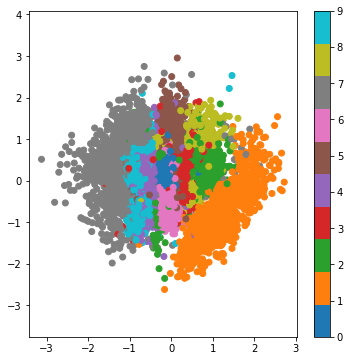

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


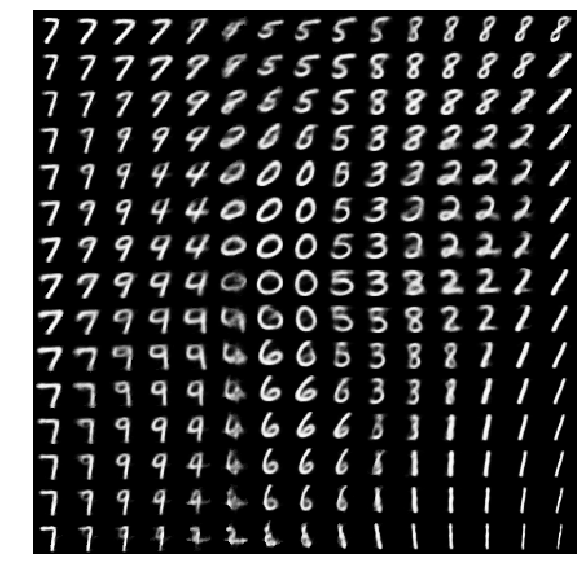

In [9]:
# display a 2D manifold of the digits
n = 15
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
plot_encoding_decoding(encoder_mean, decoder_model, x_test, grid_x, grid_y, n=n)

Minimial reconstruction error:  0.15205606818199158


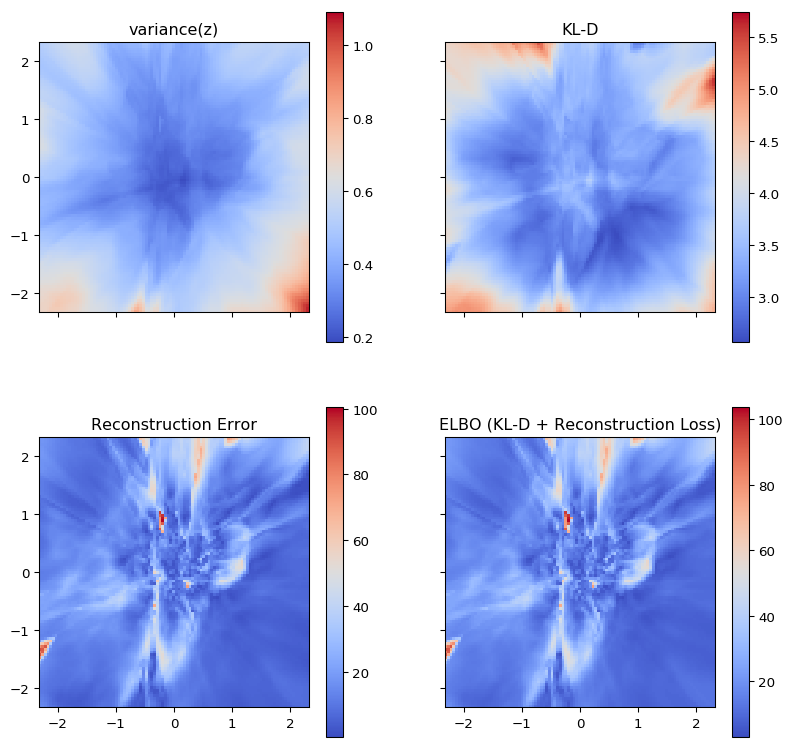

In [10]:
# Get statistics
stat_var, stat_kld, stat_elbo, stat_reconstruction, grid_x, grid_y, z_inputs, z_reencodings = \
  get_latent_space_statistics(decoder_model_stat, encoder_mean_stat, encoder_logvar_stat, encoder_decoder = None, \
                              grid_min = norm.ppf(0.01), grid_max = norm.ppf(0.99), steps = 100)

X, Y = np.meshgrid(grid_x, grid_y)
# Plot them
f, axs = plot_latent_statistics(X, Y, stat_var, stat_kld, stat_reconstruction, stat_elbo)
print("Minimial reconstruction error: ", np.min(np.min(stat_reconstruction)))

Minimial reconstruction error:  0.15205606818199158


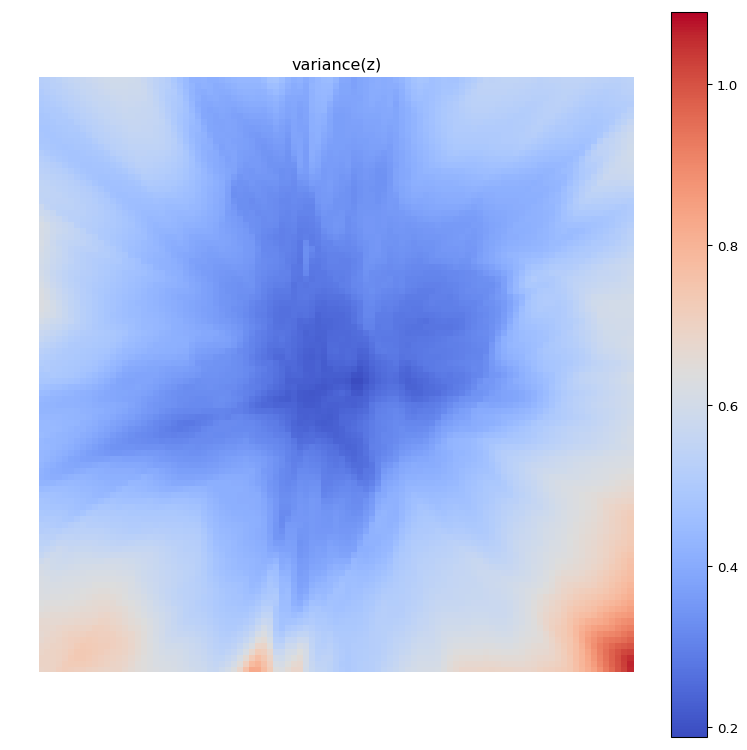

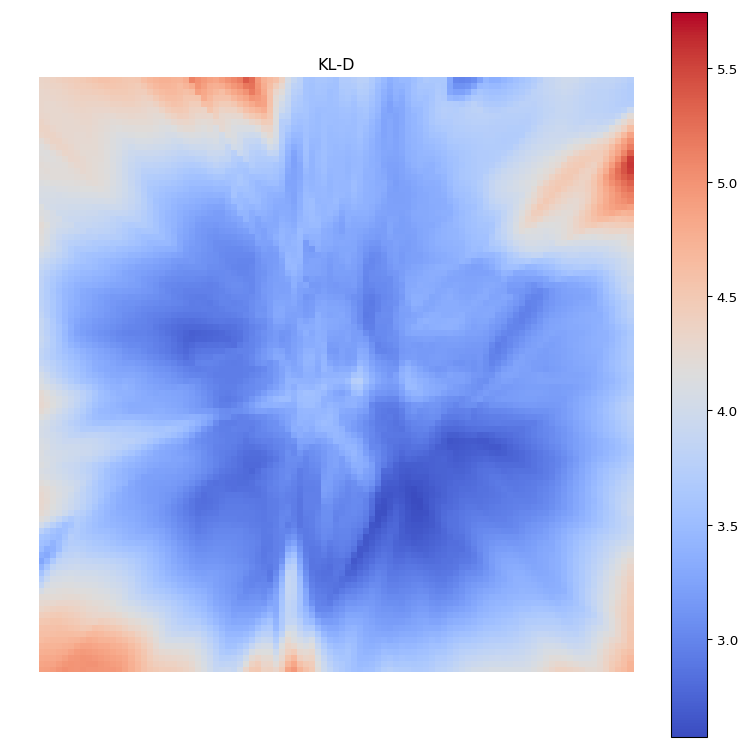

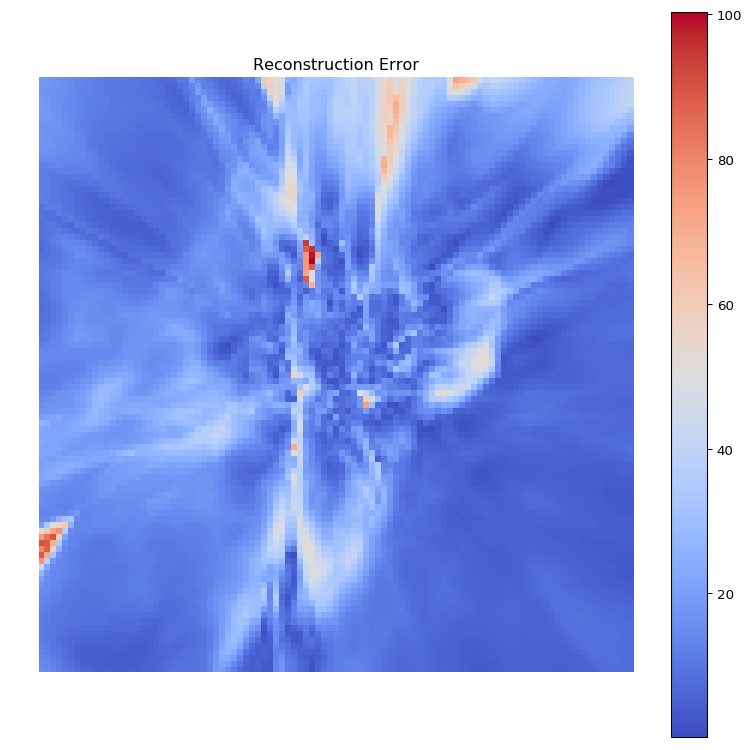

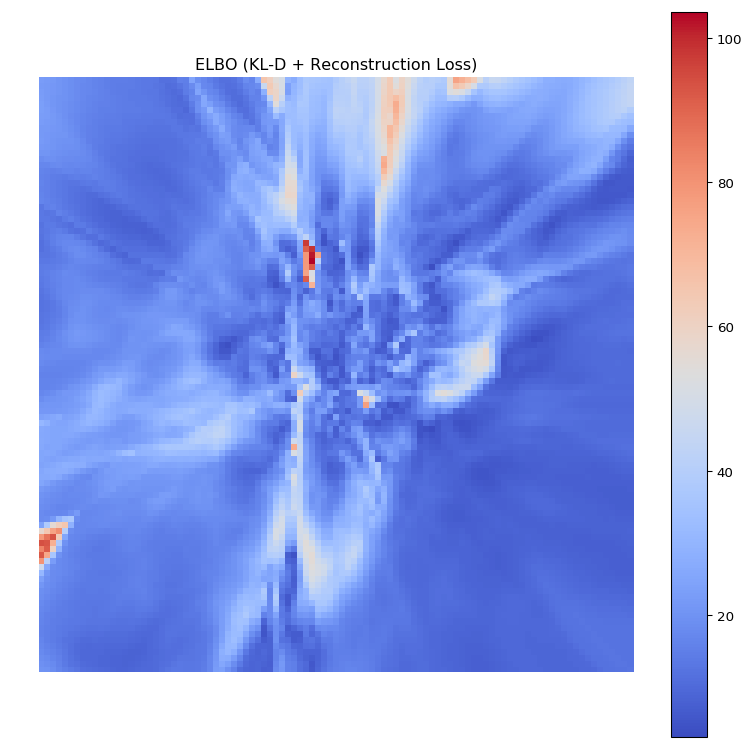

In [11]:
X, Y = np.meshgrid(grid_x, grid_y)
# Plot them
f, axs = plot_latent_statistics (X, Y, stat_var, stat_kld, stat_reconstruction, stat_elbo, use_subplots = False)
for ax in axs.flatten():
    #ax.set_title(None)
    ax.axis("off")
for _f in f.flatten():
    _f.show()
print("Minimial reconstruction error: ", np.min(np.min(stat_reconstruction)))

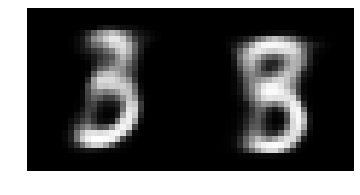

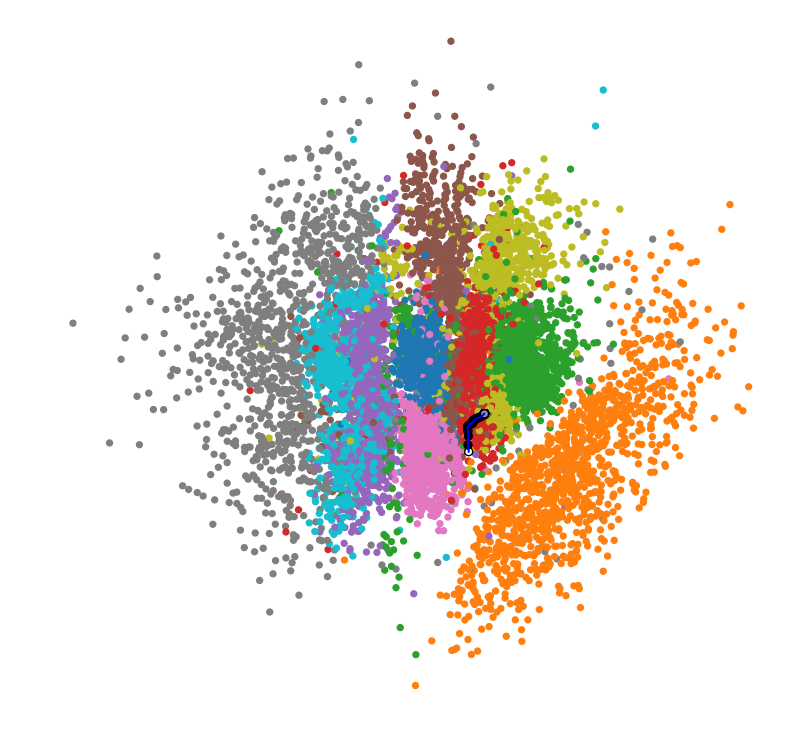

In [12]:
# Resample encoded information
steps = 200
z_mean_x = .3
z_mean_y = -.6

x, z_mean, z_logvar, custom_loss, custom_loss_origin = \
  reencode_z(decoder_model, encoder_mean, encoder_logvar, steps = steps, z_mean_init = [z_mean_x, z_mean_y], \
             custom_loss_fun = ElboGaussianPrior(reconstruction_loss = vae_tools.mmvae.ReconstructionLoss.MSE))

plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = None, plot_all_observations = False) 
#plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = stat_elbo, plot_all_observations = False) 
#plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = stat_var, plot_all_observations = False) 
#plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = stat_kld, plot_all_observations = False)

(-2.3263478740408408,
 2.3263478740408408,
 -2.3263478740408408,
 2.3263478740408408)

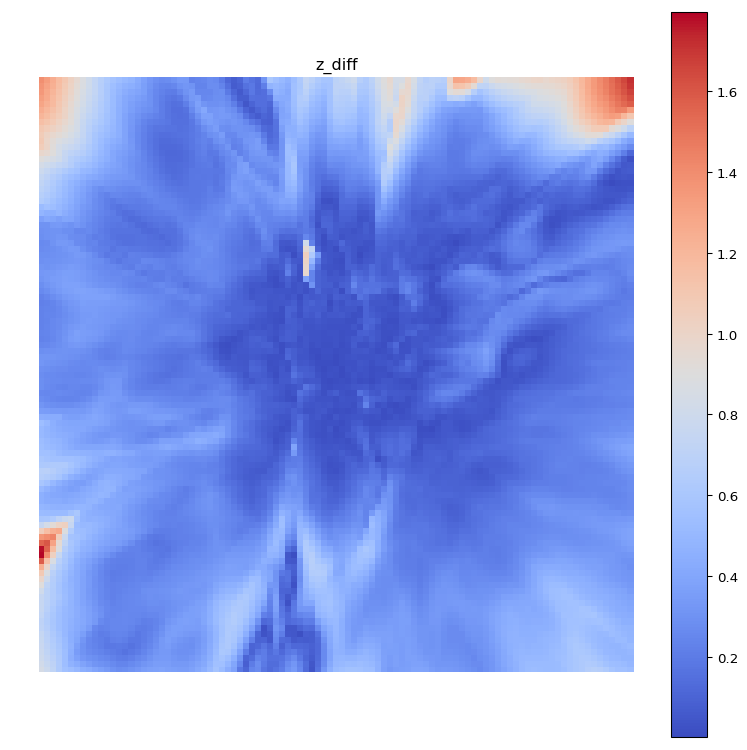

In [13]:
# Visualize the difference between z_input and the reencoded z, to show that the z remains immutable
z_diff = np.sum(np.sqrt((z_inputs - z_reencodings)**2), axis=-1)
f, axs = plt.subplots(1,1,figsize=(10,10), dpi=96)
c = axs.pcolor(X, Y, z_diff, cmap='coolwarm')
axs.set_title("z_diff")
#axs[idy,idx].axis([X.min(), X.max(), Y.min(), Y.max()])
f.colorbar(c, ax=axs)
#axs[idy,idx].axis("equal") # not allowed when sharex = True and sharey = True
axs.set_aspect("equal")
axs.axis("off")


# Train the VAE with reencoding loss

In [14]:
# # Learning z vs z'

# dec_input = Input(shape=(z_dim,), name = 'dec_input')
# encoder_model = vae_obj.get_encoder_mean([encoder[0][0]])
# decoder_model = vae_obj.get_decoder()

# z_test = encoder_model.predict(x_test, batch_size=batch_size)
# z_train = encoder_model.predict(x_train, batch_size=batch_size)

# for layer in decoder_model.layers:
#     layer.trainable = False
# dec_enc_model = keras.models.Model(dec_input, encoder_model(decoder_model(dec_input)))
    
# dec_enc_model.compile(optimizer='rmsprop', loss='mean_squared_error')
# dec_enc_model.fit(z_train,
#                   z_train,
#                   shuffle=True,
#                   epochs=epochs,
#                   batch_size=batch_size,
#                   validation_data=(z_test, z_test),
#                   verbose = 2)


In [15]:
# # Learning DKL(z) vs DKL(z')

# dec_mean_input = Input(shape=(z_dim,), name = 'dec_mean_input')
# dec_logvar_input = Input(shape=(z_dim,), name = 'dec_logvar_input')
# encoder_mean_model = vae_obj.get_encoder_mean([encoder[0][0]])
# encoder_logvar_model = vae_obj.get_encoder_logvar([encoder[0][0]])
# decoder_model = vae_obj.get_decoder()



# z_test_mean = encoder_mean_model.predict(x_test, batch_size=batch_size)
# z_test_logvar = encoder_logvar_model.predict(x_test, batch_size=batch_size)
# z_train_mean = encoder_mean_model.predict(x_train, batch_size=batch_size)
# z_train_logvar = encoder_logvar_model.predict(x_train, batch_size=batch_size)

# encoder_mean_out = encoder_mean_model(decoder_model(dec_mean_input))
# encoder_logvar_out = encoder_logvar_model(decoder_model(dec_mean_input))

# # mean?
# vae_cyclic_loss = keras.backend.sum(vae_tools.custom_variational_layer.kl_loss(dec_mean_input, encoder_mean_out, dec_logvar_input, encoder_logvar_out))
   
    
# # encoder_model(decoder_model(dec_input))

# for layer in decoder_model.layers:
#     layer.trainable = False
# #for layer in decoder_logvar_model.layers:
# #    layer.trainable = False

# dec_enc_model = keras.models.Model([dec_mean_input, dec_logvar_input], [encoder_mean_out, encoder_logvar_out])
# dec_enc_model.add_loss(vae_cyclic_loss)    
# dec_enc_model.compile(optimizer='rmsprop', loss=None)
# dec_enc_model.fit([z_train_mean, z_train_logvar],
#                   shuffle=True,
#                   epochs=epochs,
#                   batch_size=batch_size,
#                   validation_data=([z_test_mean, z_test_logvar], None),
#                   verbose = 0)



In [16]:
# Learning joint ELBO and DKL(z) vs. DKL(z')

encoder_mean_model = vae_obj.get_encoder_mean([encoder[0][0]])
encoder_logvar_model = vae_obj.get_encoder_logvar([encoder[0][0]])
decoder_model = vae_obj.get_decoder()

sampling_layer_obj = vae_tools.sampling.Sampling(z_dim = 2)
sampling_layer = Lambda(sampling_layer_obj.randn, output_shape=(z_dim,), name='sample')

encoder_mean_model_out1 = encoder_mean_model(encoder[0][0])
encoder_logvar_model_out1 = encoder_logvar_model(encoder[0][0])
decoder_model_out = decoder_model(sampling_layer([encoder_mean_model_out1, encoder_logvar_model_out1]))
encoder_mean_model_out = encoder_mean_model(decoder_model_out)
encoder_logvar_model_out = encoder_logvar_model(decoder_model_out)

#encoder_mean_out = encoder_mean_model(decoder_model(dec_mean_input))
#encoder_logvar_out = encoder_logvar_model(decoder_model(dec_mean_input))

vae_cyclic_loss = keras.backend.sum(vae_tools.custom_variational_layer.kl_loss(encoder_mean_model_out1, encoder_mean_model_out, encoder_logvar_model_out1, encoder_logvar_model_out))
vae_kl_loss = keras.backend.sum(vae_tools.custom_variational_layer.kl_loss_n(encoder_mean_model_out1, encoder_logvar_model_out1), axis=-1)
vae_reconstruction = original_dim * keras.losses.mse(encoder[0][0], decoder_model_out)

loss = keras.backend.mean(vae_reconstruction + vae_kl_loss + 0.1 * vae_cyclic_loss)
#loss = keras.backend.mean(vae_reconstruction + vae_kl_loss)
# encoder_model(decoder_model(dec_input))

#for layer in decoder_model.layers:
#    layer.trainable = False
#for layer in decoder_logvar_model.layers:
#    layer.trainable = False

dec_enc_model = keras.models.Model(encoder[0][0], [encoder_mean_model_out, encoder_logvar_model_out])
#dec_enc_model = keras.models.Model(encoder[0][0], decoder_model_out)
#dec_enc_model.add_loss(vae_cyclic_loss)
#dec_enc_model.add_loss(vae_kl_loss)
#dec_enc_model.add_loss(vae_reconstruction)
dec_enc_model.add_loss(loss)
dec_enc_model.compile(optimizer='rmsprop', loss=None)
dec_enc_model.fit(x_train,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(x_test, None),
                  verbose = 0)
#vae_tools.viz.plot_model(dec_enc_model, file = 'myVAE', print_svg = False, verbose = True)

In [17]:
decoder_model, encoder_mean, encoder_logvar, encoder_decoder = load_store_models(vae_obj, encoder_input, prefix, suffix = "_ext")

Saved model /tmp/5434746408379360160decoder_ext to disk
Saved weights of model /tmp/5434746408379360160decoder_ext to disk
Saved model /tmp/5434746408379360160encoder_mean_ext to disk
Saved weights of model /tmp/5434746408379360160encoder_mean_ext to disk
Saved model /tmp/5434746408379360160encoder_logvar_ext to disk
Saved weights of model /tmp/5434746408379360160encoder_logvar_ext to disk
Saved model /tmp/5434746408379360160encoder_decoder_ext to disk
Saved weights of model /tmp/5434746408379360160encoder_decoder_ext to disk


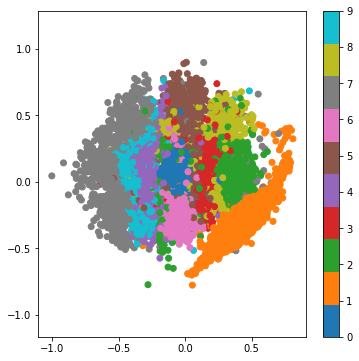

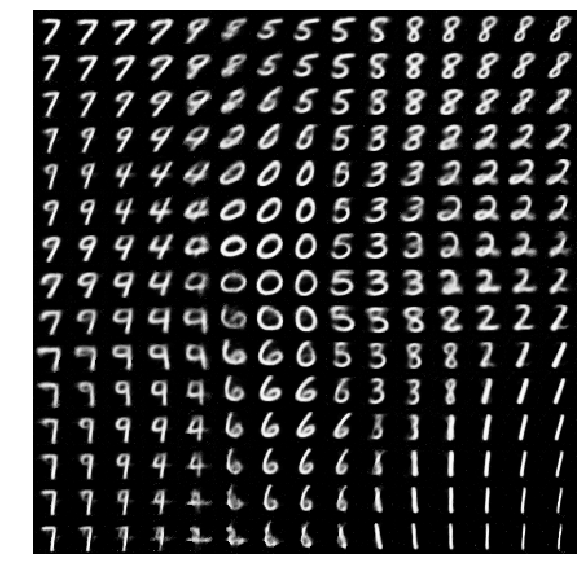

In [18]:
# Plot encoding and decoding
n = 15
grid_x = np.linspace(-0.5, 0.5, n)
grid_y = np.linspace(-0.5, 0.5, n)
plot_encoding_decoding(encoder_mean, decoder_model, x_test, grid_x, grid_y, n=n)

Minimial reconstruction error:  0.014986171387135983


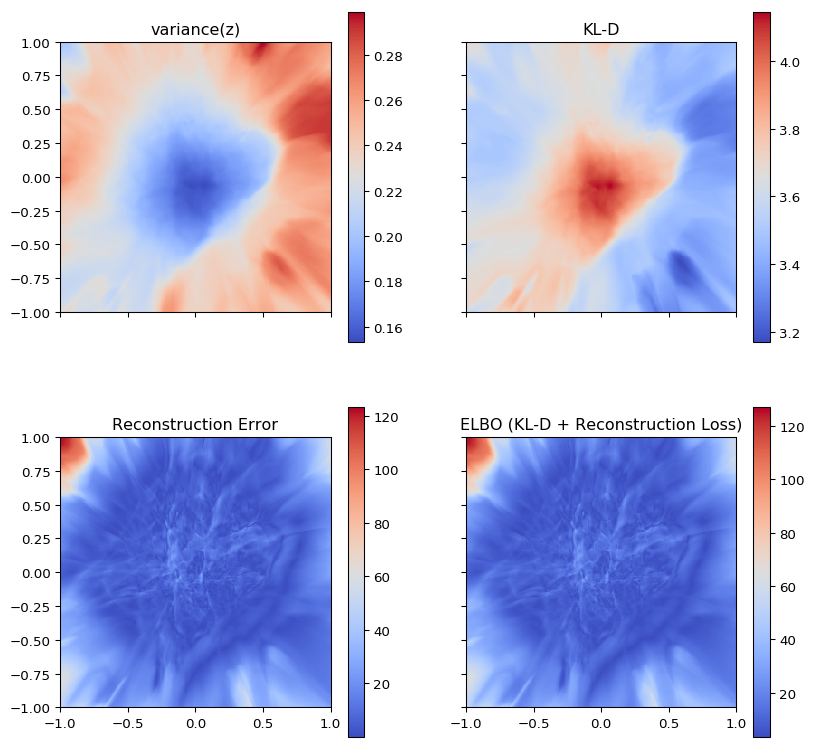

In [27]:
# Get statistics
stat_var, stat_kld, stat_elbo, stat_reconstruction, grid_x, grid_y, z_inputs, z_reencodings = \
  get_latent_space_statistics(decoder_model, encoder_mean, encoder_logvar, encoder_decoder = None,  grid_min = -1., grid_max = 1., steps = 100)

X, Y = np.meshgrid(grid_x, grid_y)
# Plot them
f, axs = plot_latent_statistics (X, Y, stat_var, stat_kld, stat_reconstruction, stat_elbo)
print("Minimial reconstruction error: ", np.min(np.min(stat_reconstruction)))

Minimial reconstruction error:  0.014986171387135983


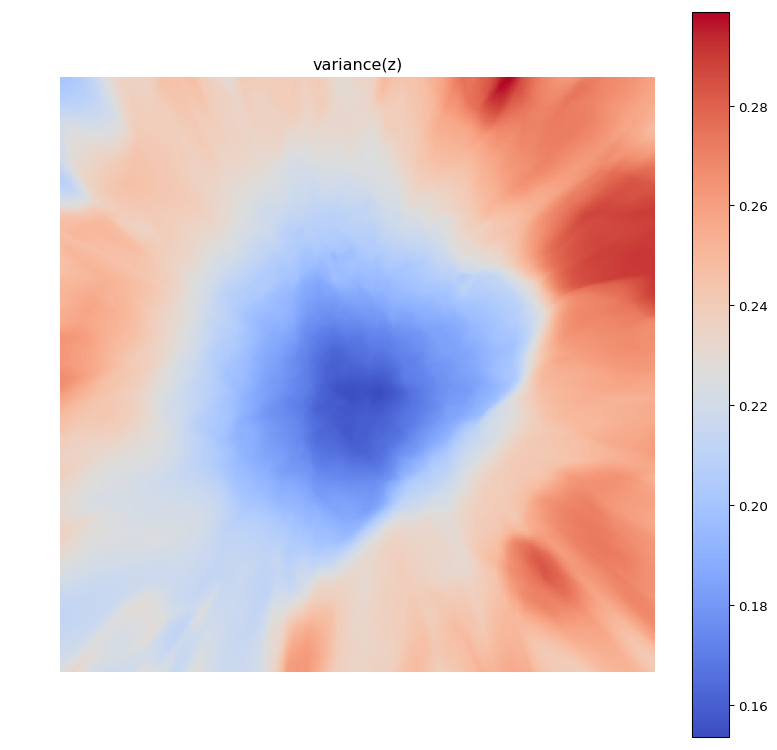

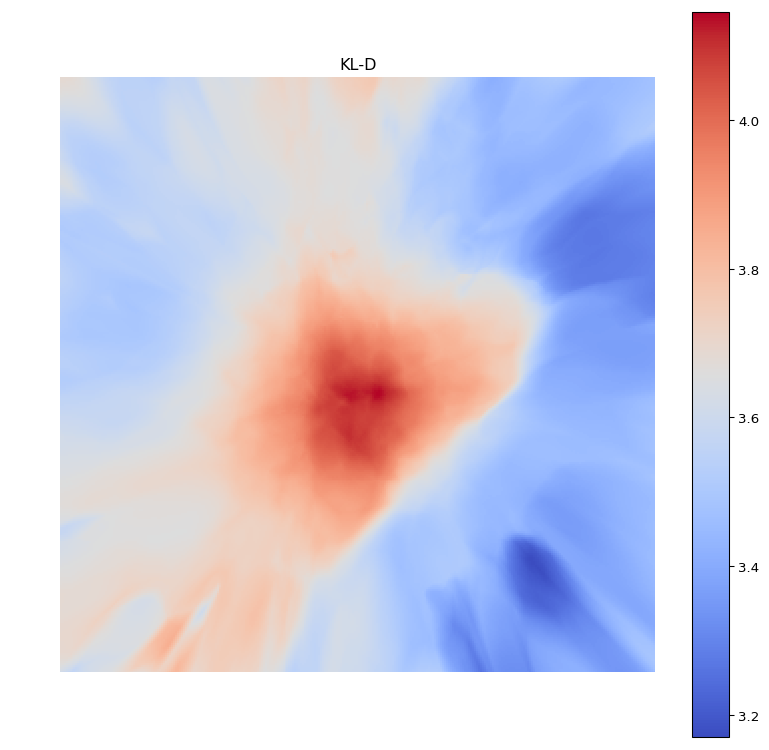

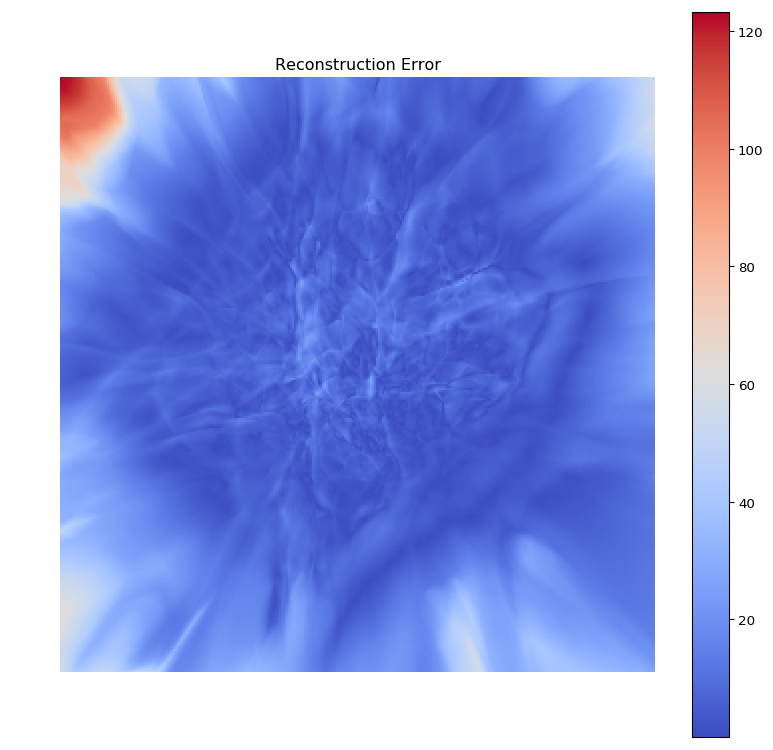

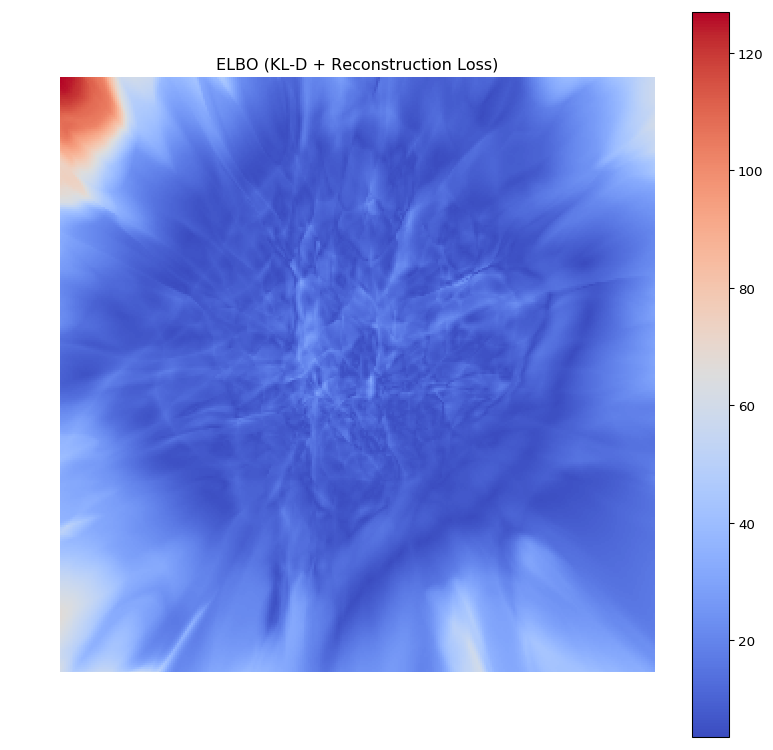

In [28]:
X, Y = np.meshgrid(grid_x, grid_y)
# Plot them
f, axs = plot_latent_statistics (X, Y, stat_var, stat_kld, stat_reconstruction, stat_elbo, use_subplots = False)
for ax in axs.flatten():
    #ax.set_title(None)
    ax.axis("off")
for _f in f.flatten():
    _f.show()
print("Minimial reconstruction error: ", np.min(np.min(stat_reconstruction)))

(-1.0, 1.0, -1.0, 1.0)

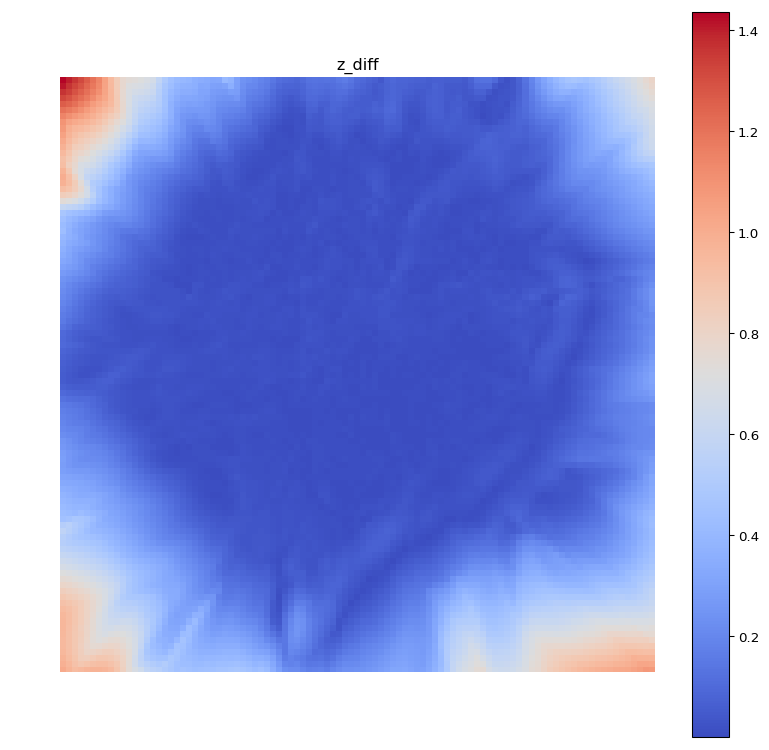

In [21]:
# Visualize the difference between z_input and the reencoded z, to show that the z remains immutable
z_diff = np.sum(np.sqrt((z_inputs - z_reencodings)**2), axis=-1)

f, axs = plt.subplots(1,1,figsize=(10,10), dpi=96)
c = axs.pcolor(X, Y, z_diff, cmap='coolwarm')
axs.set_title("z_diff")
#axs[idy,idx].axis([X.min(), X.max(), Y.min(), Y.max()])
f.colorbar(c, ax=axs)
#axs[idy,idx].axis("equal") # not allowed when sharex = True and sharey = True
axs.set_aspect("equal")
axs.axis("off")


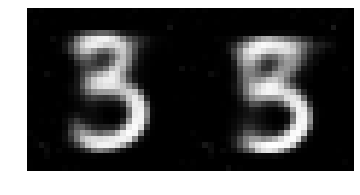

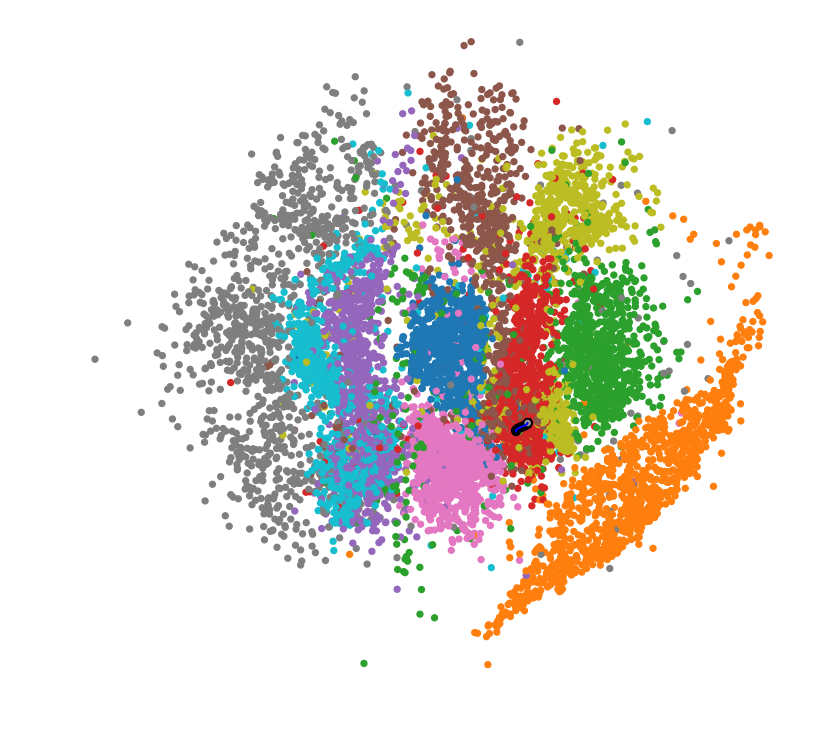

In [26]:
# Resample encoded information and plot the latent space
steps = 400
z_mean_x = 0.13
z_mean_y = -0.15

x, z_mean, z_logvar, custom_loss, custom_loss_origin = \
  reencode_z(decoder_model, encoder_mean, encoder_logvar, steps = steps, z_mean_init = [z_mean_x, z_mean_y], \
             custom_loss_fun = ElboGaussianPrior(reconstruction_loss = vae_tools.mmvae.ReconstructionLoss.MSE))

plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = None, plot_all_observations = False) 
#plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = stat_elbo, plot_all_observations = False) 
#plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = stat_var, plot_all_observations = False) 
#plot_reencoding(X,Y, x, z_mean, x_encoded = encoder_mean.predict(x_test), steps = steps, stat_values = stat_kld, plot_all_observations = False)